In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import functional as VF
from torchmetrics.classification import BinaryJaccardIndex
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
import pandas as pd
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import random

# Preparing the data - Fill NA values

In [6]:
data_dir = './train/images/'
data_dict = []
pattern = r'well_(\d+)_patch_(\d+)\.npy'
for i, filename in enumerate(os.listdir(data_dir)):
  example = np.load(data_dir + filename)
  match = re.match(pattern, filename)
  if match:
    well_number = int(match.group(1))  # Extract well number
    patch_number = int(match.group(2)) # Extract patch number
  else:
    print("Filename format does not match the expected pattern.")  
  
  data_dict.append((filename, well_number, patch_number, example.flatten()))

df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])

In [7]:
df_y = pd.read_csv('train/y_train.csv')
df_y['Unnamed: 0'] = df_y['Unnamed: 0'] + '.npy'

In [77]:
merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
data_columns = [str(i) for i in range(1296)]
labeled_data = merged[data_columns].to_numpy()
merged['labels'] = labeled_data.tolist()
merged = merged.rename(columns={'Unnamed: 0':'label_name'})

In [149]:
matched_wells = merged[merged['label_name'].notna()]

In [107]:
# This confirms that all values for which we have a label have at least one value above 0.0
# So we can fill missing values with 0.0

non_zero_columns = (matched_wells[data_columns] != 0.0).any()
non_zero_columns = non_zero_columns[non_zero_columns == True]
matched_wells[non_zero_columns.index]

,3,4,5,6,7,8,9,10,11,16,...,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [8]:
merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
data_columns = [str(i) for i in range(1296)]
labeled_data = merged[data_columns].to_numpy()
labeled_data = np.nan_to_num(labeled_data)
merged['labels'] = labeled_data.tolist()
merged = merged.rename(columns={'Unnamed: 0':'label_name'})
merged = merged.fillna(0.0)

# Look for outlier values

In [171]:
data = torch.from_numpy(np.vstack(merged['data'].to_numpy(dtype=np.ndarray)))
data.shape

torch.Size([2538, 1296])

(array([ 175.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2363.]),
 array([-9.99250000e+02, -8.99326050e+02, -7.99402039e+02, -6.99478088e+02,
        -5.99554077e+02, -4.99630096e+02, -3.99706116e+02, -2.99782166e+02,
        -1.99858170e+02, -9.99341965e+01, -1.02152824e-02]),
 <BarContainer object of 10 artists>)

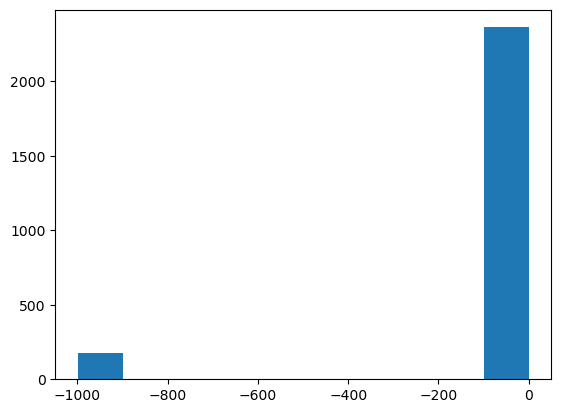

In [233]:
plt.hist(data.min(dim=1, keepdim=True).values.flatten())

In [9]:
outliers = ((data.min(dim=1, keepdim=True).values == -999.2500) == True).flatten()
outliers.shape

NameError: name 'data' is not defined

In [ ]:
merged = merged.drop(merged.loc[outliers.tolist()].index)

# Set up DataLoader

In [4]:
class WellsDataset(Dataset):
    def __init__(self, data, labels, transform):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = False
        self.scaler = RobustScaler()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(1, 36, 36).float()
        label = self.labels[idx].reshape(1,36, 36)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
def build_dataloaders(dataframe):
    data = torch.from_numpy(np.vstack(dataframe['data'].to_numpy()))
    labels = torch.from_numpy(np.vstack(dataframe['labels'].to_numpy()))

    p = np.random.permutation(len(data))
    data, labels = data[p], labels[p]

    offset = int(len(data) * .8)
    X_train, X_valid = data[:offset], data[offset:]
    Y_train, Y_valid = labels[:offset].float(), labels[offset:].float()

    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train = torch.tensor(scaler.transform(X_train)).float()
    X_valid = torch.tensor(scaler.transform(X_valid)).float()
    
    flipper = v2.RandomVerticalFlip(1)
    X_train_flipped, Y_train_flipped = flipper(X_train), flipper(Y_train)

    train_dataset = WellsDataset(torch.vstack((X_train, X_train_flipped)), torch.vstack((Y_train, Y_train_flipped)), None)
    valid_dataset = WellsDataset(X_valid, Y_valid, None)

    train_dataloader = DataLoader(train_dataset, batch_size=128)
    valid_dataloader = DataLoader(valid_dataset, batch_size=128)

    return train_dataloader, valid_dataloader


NameError: name 'Dataset' is not defined

# View Samples

In [578]:
train_dl, valid_dl = build_dataloaders(merged)
samples, labels = next(iter(train_dl))

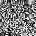

In [480]:
VF.to_pil_image(samples[0])

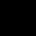

In [481]:
VF.to_pil_image(labels[0])

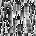

In [482]:
VF.to_pil_image(samples[1])

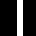

In [483]:
VF.to_pil_image(labels[1])

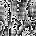

In [484]:
VF.to_pil_image(samples[7])

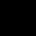

In [485]:
VF.to_pil_image(labels[7])

# Implement the Baseline Model

- The CNN architecture consists of 5 layers without pooling.
- A batch size of 128 was chosen to optimize computational efficiency during the training process.
- The learning rate was set at 0.001 to guide the model through effective convergence.
- Training was conducted over 30 epochs to capture the temporal evolution of features within the data.
- Utilizing the Binary Cross Entropy loss function facilitated effective optimization, striking a balance between the dice coefficient and the binary cross-entropy components.
- Data augmentation techniques, including flip and horizontal roll, were strategically incorporated to enhance the model's adaptability.
- The optimizer used during training was the Adam optimizer

In [3]:
class Baseline(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    num_channels = 64
    self.feature_extractor = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=num_channels, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels, out_channels=num_channels*2, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels*2, out_channels=num_channels*2, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_channels*2, out_channels=1, kernel_size=3, padding=1),
      nn.ReLU(),
    )
    self.classifier = nn.Sequential(
      nn.Sigmoid()
    )
  
  def forward(self, input):
    x = self.feature_extractor(input)
    return self.classifier(x)
  
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

NameError: name 'nn' is not defined

In [1]:
def train(train_dataloaer, validation_dataloader, num_epochs, lr):
  model = Baseline()
  optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
  metric = BinaryJaccardIndex()
  criterion = DiceLoss()
  for e in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    for input, labels in tqdm(iter(train_dataloaer)):
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, labels)
      train_loss += loss.item()
      iou = metric(output, labels)
      train_iou += iou.item()
      loss.backward()
      optimizer.step()

    model.eval()
    valid_loss = 0
    valid_iou = 0
    with torch.no_grad():
      for input, labels in tqdm(iter(validation_dataloader)):
        out = model(input)
        loss = criterion(out, labels)
        iou = metric(out, labels)
        valid_loss += loss.item()
        valid_iou += iou.item()
    
    print(f'Epoch: {e}')
    print(f'Train loss:      {train_loss / len(train_dataloaer)}')
    print(f'Validation loss: {valid_loss / len(validation_dataloader)}')
    print(f'Train intersection over union:      {train_iou}')
    print(f'Validation intersection over union: {valid_iou}')

In [2]:
train_dl, valid_dl = build_dataloaders(merged)
train(train_dl, valid_dl, 30, 0.001)

NameError: name 'build_dataloaders' is not defined